In [21]:
#pip install tensorflow

Nesse projeto uso LSTM para descobrir qual é o preço de fechamento do bitcoin. Uso 5 features relativas ao candle de negociação diária e prevejo o preço de fechamento do dia seguinte



In [22]:
# Importar as bibliotecas necessárias
import os
import pandas as pd
import numpy as np
import math
import datetime
import time

# Importar sklearn para avaliar o modelo
from sklearn.metrics import mean_squared_error, mean_absolute_error, explained_variance_score, r2_score
from sklearn.metrics import mean_poisson_deviance, mean_gamma_deviance, accuracy_score
from sklearn.preprocessing  import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import confusion_matrix


# Importar tensorflow para construir o modelo
import tensorflow as tf
import keras
from keras import optimizers
from keras.models import Sequential, Model
from keras.layers import *
from keras.callbacks import ModelCheckpoint, History, EarlyStopping
from keras.losses import MeanSquaredError
from keras.metrics import RootMeanSquaredError
from keras.optimizers import Adam

# Importar bibliotecas para plotar gráficos

import matplotlib.pyplot as plt
from itertools import cycle
import plotly.graph_objects as go
import plotly.express as px
from plotly.subplots import make_subplots



## Variaveis Globais

In [23]:
TIME_STEP = 30
JUMP_STEP = 1
NUM_FEATURES = 5
# usando apenas o Close


## Importar a Base de Dados

In [24]:
ticker = 'BTC-USD'
#1410825600
initial_period = int(time.mktime(datetime.datetime(2014, 9, 16, 0, 0).timetuple()))

#1675814400
final_period = int(time.mktime(datetime.datetime(2023, 2, 8, 0, 0).timetuple()))
# 3067 valores. 2300 é 75%
interval = '1d' # 1d, 1wk, 1m

query_string = f'https://query1.finance.yahoo.com/v7/finance/download/{ticker}?period1={initial_period}&period2={final_period}&interval={interval}&events=history&includeAdjustedClose=true'

data = pd.read_csv(query_string)
df = pd.DataFrame(data, columns=['Date', 'Open', 'High', 'Low', 'Close', 'Volume'])
df.index = pd.to_datetime(df['Date'], format='%Y-%m-%d')


Função para escolher os dados utilizados de forma sequencial. A cada t valores


In [25]:
def selecionaValores(df, jump_step):
  return df[0::jump_step]

df = selecionaValores(df, JUMP_STEP)

Preparação dos Dados:

In [26]:
# Retira a Data e coloca como Index
df.index = df.pop('Date')

# Adição da coluna de variação
df['TargetChange'] = df.Close.shift(-1) - df['Close']
# Adição da coluna de variação percentual
df['TargetVariation'] = (df['TargetChange'] / df['Close'])*100
# Adição da coluna de classificação
# Adição da coluna de Valor Final
df['TargetClose'] = df['Close'].shift(-1)

# df.pop('TargetVariation')
# df.pop('TargetClass')
# df.pop('TargetClose')
data.dropna(inplace=True)
data.reset_index(inplace = True)


In [27]:
len(df)

3067

In [28]:
df.head(20)

,Open,High,Low,Close,Volume,TargetChange,TargetVariation,TargetClose
Date,,,,,,,,
2014-09-17,465.864014,468.174011,452.421997,457.334015,21056800,-32.894013,-7.192558,424.440002
2014-09-18,456.859985,456.859985,413.104004,424.440002,34483200,-29.644012,-6.984264,394.795990
2014-09-19,424.102997,427.834991,384.532013,394.795990,37919700,14.108002,3.573492,408.903992
2014-09-20,394.673004,423.295990,389.882996,408.903992,36863600,-10.082978,-2.465855,398.821014
2014-09-21,408.084991,412.425995,393.181000,398.821014,26580100,3.330994,0.835210,402.152008
2014-09-22,399.100006,406.915985,397.130005,402.152008,24127600,33.638977,8.364742,435.790985
2014-09-23,402.092010,441.557007,396.196991,435.790985,45099500,-12.585998,-2.888081,423.204987
2014-09-24,435.751007,436.112000,421.131989,423.204987,30627700,-11.630982,-2.748309,411.574005
2014-09-25,423.156006,423.519989,409.467987,411.574005,26814400,-7.149017,-1.736994,404.424988


In [29]:
df.tail()

,Open,High,Low,Close,Volume,TargetChange,TargetVariation,TargetClose
Date,,,,,,,,
2023-02-04,23446.320313,23556.949219,23291.794922,23331.847656,15639298538,-376.181640,-1.612310,22955.666016
2023-02-05,23332.248047,23423.435547,22841.759766,22955.666016,19564262605,-195.556641,-0.851888,22760.109375
2023-02-06,22954.021484,23119.279297,22692.025391,22760.109375,23825006542,504.181641,2.215199,23264.291016
2023-02-07,22757.267578,23310.974609,22756.257813,23264.291016,27187964471,-324.892578,-1.396529,22939.398438
2023-02-08,23263.416016,23367.958984,22731.097656,22939.398438,25371367758,NaN,NaN,NaN


In [30]:
#plt.plot(df.index, df['Close'])

In [31]:
# Separa as Features do Valor Final
# Separa X de Y e Retira a última linha
#df.pop('Open')
#df.pop('High')
#df.pop('Low')
#df.pop('Volume')

#y_array = np.array(df.TargetVariation)[:-1].copy()
df.pop('TargetChange')
df.pop('TargetVariation')
#df.pop('TargetClose')
x_array = np.array(df)[:-1].copy() #ignora a última linha, pois não há targetClose


In [34]:
# Divisão entre 70% treino, 10% validação e 20% teste
size = len(df-1) - TIME_STEP
train_size = int(size * 0.7)
validation_size = int(size * 0.1)
test_size = size - train_size - validation_size

train_data = x_array[: train_size]
val_data = x_array[train_size : (train_size + validation_size)]
test_data = x_array[(train_size + validation_size) :]


In [35]:
#Transforma os dados para suavizar as variações em escala absoluta
# Transform input data
scaler_train_input = MinMaxScaler(feature_range=(0, 1))
scaled_train_input = scaler_train_input.fit_transform(train_data[:,:-1])

scaler_val_input = MinMaxScaler(feature_range=(0, 1))
scaled_val_input = scaler_val_input.fit_transform(val_data[:,:-1])

scaler_test_input = MinMaxScaler(feature_range=(0, 1))
scaled_test_input = scaler_test_input.fit_transform(test_data[:,:-1])

# Transform output data
scaler_train_output = MinMaxScaler(feature_range=(0, 1))
scaled_train_output = scaler_train_output.fit_transform(train_data[:,-1].reshape(-1, 1))

scaler_val_output = MinMaxScaler(feature_range=(0, 1))
scaled_val_output = scaler_val_output.fit_transform(val_data[:,-1].reshape(-1, 1))

scaler_test_output = MinMaxScaler(feature_range=(0, 1))
scaled_test_output = scaler_test_output.fit_transform(test_data[:,-1].reshape(-1, 1))

In [36]:
def createDataset(x, y, time_step=1):
  input = []
  output = []
  for i in range(len(x) - time_step):
    row = [e for e in x[i : i + time_step]]
    input.append(row)
    output.append(y[i])
  return np.array(input), np.array(output)

x_train, y_train = createDataset(scaled_train_input, scaled_train_output, TIME_STEP)
x_val, y_val = createDataset(scaled_val_input, scaled_val_output, TIME_STEP)
x_test, y_test = createDataset(scaled_test_input, scaled_test_output, TIME_STEP)

print(df.shape)
print(x_train.shape, y_train.shape)
print(x_val.shape, y_val.shape)
print(x_test.shape, y_test.shape)

(3067, 6)
(2095, 30, 5) (2095, 1)
(273, 30, 5) (273, 1)
(608, 30, 5) (608, 1)


## Construção do Modelo LSTM

### Modelo: LSTM



In [37]:
#create the sequence model
model = Sequential()

model.add(LSTM(units = 64, activation = 'relu', return_sequences=False, input_shape = (x_train.shape[1], x_train.shape[2])))
# model.add(Dropout(0.2))
# model.add(LSTM(units = 64, input_shape = (x_train.shape[1], x_train.shape[2])))

model.add(Dense(units=1))
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_1 (LSTM)               (None, 64)                17920     
                                                                 
 dense_1 (Dense)             (None, 1)                 65        
                                                                 
Total params: 17,985
Trainable params: 17,985
Non-trainable params: 0
_________________________________________________________________


In [ ]:
model.compile(optimizer = 'adam', loss = 'mean_squared_error')
checkpoint_path = 'tcc_regressao_1.hdf5'
checkpoint = ModelCheckpoint(filepath=checkpoint_path,
                             monitor='val_loss',
                             verbose=1,
                             save_best_only=True,
                             mode='min')
earlystopping = EarlyStopping(monitor='val_loss', patience=50, restore_best_weights=True)
callbacks = [checkpoint, earlystopping]

history = model.fit(x_train, y_train, batch_size = 32, epochs = 500, verbose=1, shuffle=False, validation_data=(x_val, y_val), callbacks=callbacks)

## Previsões e Métricas


In [39]:
from tensorflow.keras.models import load_model

model_from_saved_checkpoint = load_model(checkpoint_path)

In [ ]:
test_predict = model_from_saved_checkpoint.predict(x_test)

test_predict = scaler_test_output.inverse_transform(test_predict.reshape(-1, 1))

test_actual = scaler_test_output.inverse_transform(y_test.reshape(-1, 1))

In [53]:
# Calculate regression metrics
mse = mean_squared_error(test_actual, test_predict)
rmse = np.sqrt(mse)
mae = mean_absolute_error(test_actual, test_predict)
r2 = r2_score(test_actual, test_predict)

# Print the metrics
print(f"Mean Squared Error (MSE): {mse}")
print(f"Root Mean Squared Error (RMSE): {rmse}")
print(f"Mean Absolute Error (MAE): {mae}")
print(f"Coefficient of Determination (R-squared): {r2}")

Mean Squared Error (MSE): 1576426.9163767006
Root Mean Squared Error (RMSE): 1255.5584081900374
Mean Absolute Error (MAE): 931.2722649936267
Coefficient of Determination (R-squared): 0.99134699996009


## Gráficos

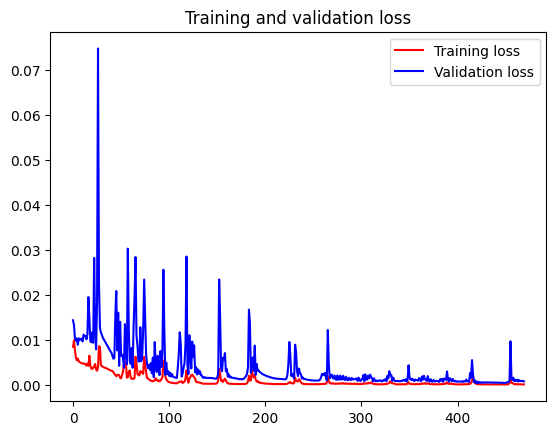

<Figure size 640x480 with 0 Axes>

In [43]:
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(len(loss))

plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend(loc=0)
plt.figure()


plt.show()

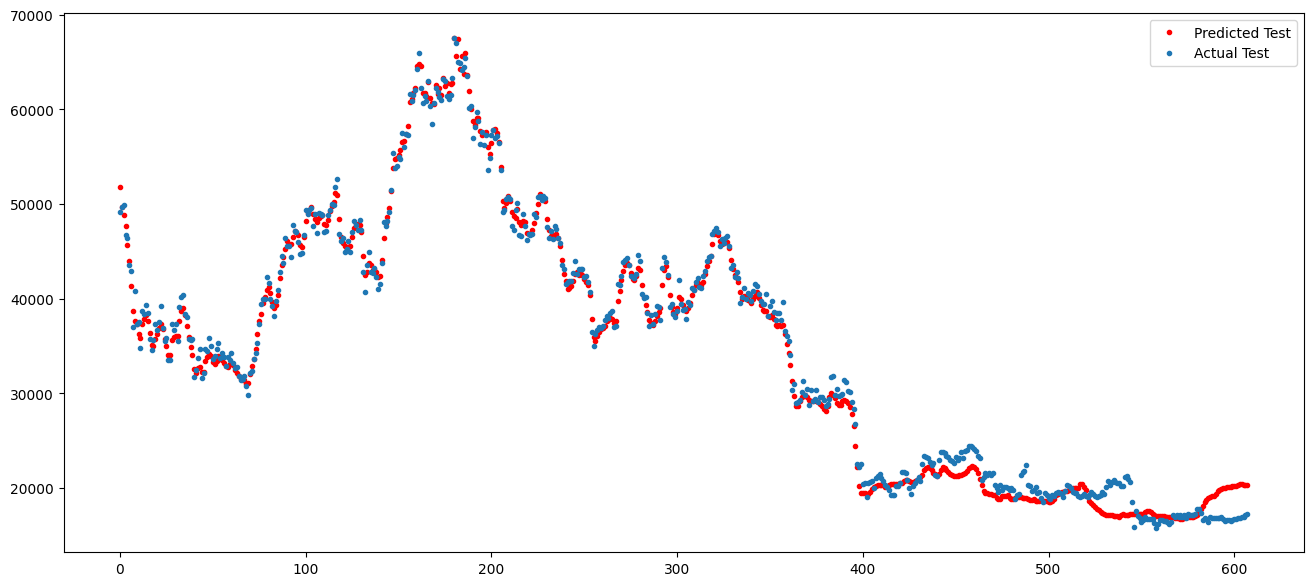

In [48]:

plt.figure(figsize=(16,7))

plt.plot(test_predict, 'r', marker='.', label='Predicted Test', linewidth=0)

plt.plot(test_actual, marker='.', label='Actual Test',linewidth=0)

plt.legend()
plt.show()

Plotar o Gráfico